# Data Management

## Setup

In [1]:
# Import modules
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from scipy.spatial.distance import cdist

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances


In [2]:
# Load data
df = pd.read_excel('/Users/julienmbarki/Documents/Doctorat/Publications/Article 2/Data/Code/data_requests/df_voyage.xlsx')

# Group by playlist name
groups = df.groupby('playlist_name')


## PCA dimensionnality reduction

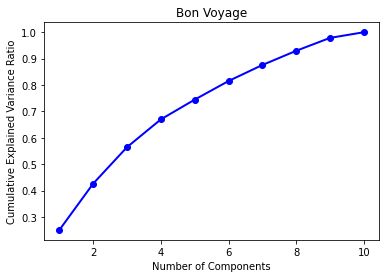

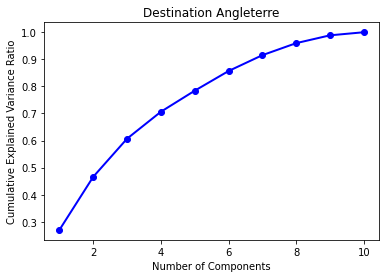

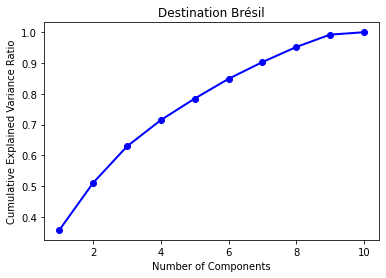

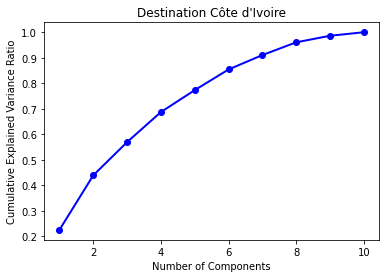

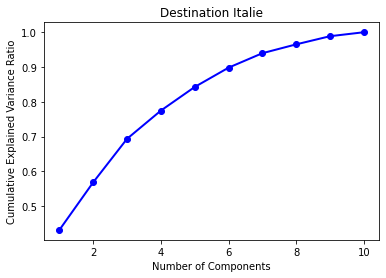

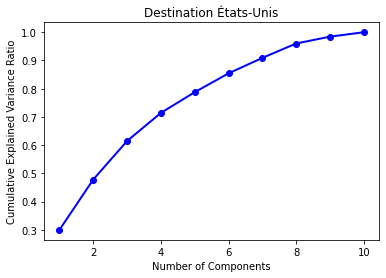

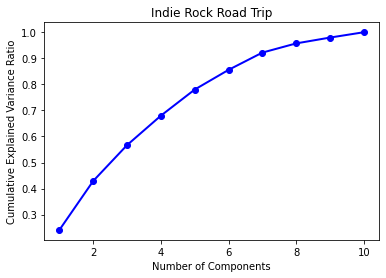

Most modal value of optimal components: 6


In [3]:
# Select the number of components
scaler = MinMaxScaler()

selected_columns = [
    "danceability", "energy", "loudness", "speechiness", 
    "acousticness", "instrumentalness", "liveness", "valence", 
    "tempo", "duration_ms"
]

optimal_num_components = []

for group_name, group in groups:
    # Subset and scale
    subset = group.loc[:, selected_columns]
    scaled_columns = scaler.fit_transform(subset)

    # Apply PCA
    pca = PCA()
    pca.fit(scaled_columns)
    
    # Calculate cumulative explained variance
    cumulative_variance = pca.explained_variance_ratio_.cumsum()
    optimal_components = next(i for i, var in enumerate(cumulative_variance) if var >= 0.8) + 1
    optimal_num_components.append(optimal_components)

    # Plot scree plot
    plt.plot(range(1, pca.n_components_ + 1), cumulative_variance, 'bo-', linewidth=2)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title(group_name)
    plt.show()

# Calculate the most modal value
most_common_optimal = Counter(optimal_num_components).most_common(1)
most_modal_value = most_common_optimal[0][0]

print("Most modal value of optimal components:", most_modal_value)


In [4]:
# Apply PCA to reduce dimensionality
# Loop over each group and apply PCA with optimal number of components
scaler = MinMaxScaler()

selected_columns = [
    "danceability", "energy", "loudness", "speechiness", 
    "acousticness", "instrumentalness", "liveness", "valence", 
    "tempo", "duration_ms"
]

reduced_data_dict = {}

for group_name, group in groups:
    # Subset data
    subset = group.loc[:, selected_columns]

    # Scale the specified columns
    scaled_columns = scaler.fit_transform(subset)

    # Apply PCA with the optimal number of components
    n_components = 6
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_columns)
    reduced_data_dict[group_name] = reduced_data


## Clustering

### Elbow method

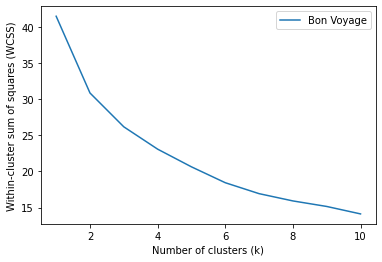

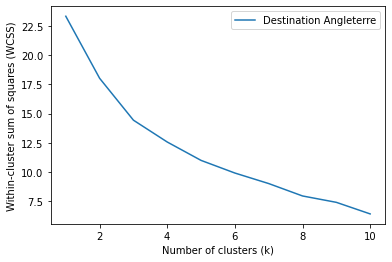

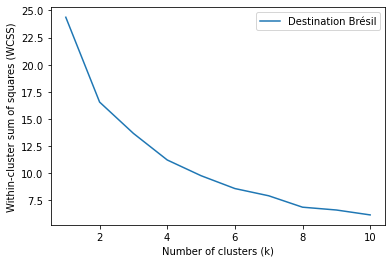

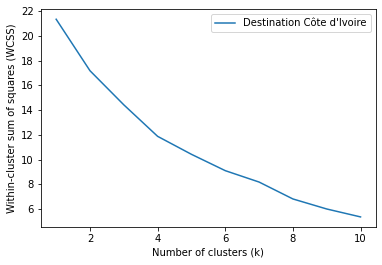

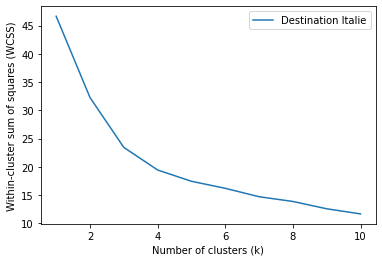

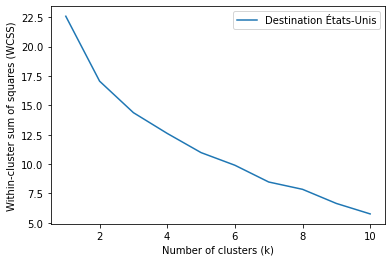

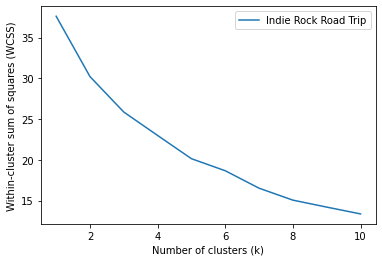

In [5]:
# Apply the elbow method to determine the optimal number of clusters
# Calculate the elbow
wcss = {}

for k in range(1, 11):
  for group_name, group in groups:
    reduced_data = reduced_data_dict[group_name]
    
    kmeans = KMeans(n_clusters=k, random_state=42).fit(reduced_data)
    
    if group_name not in wcss:
      wcss[group_name] = []

    wcss[group_name].append(kmeans.inertia_)

# Plot the elbow
for group_name, values in wcss.items():
  plt.plot(range(1, 11), values, label=group_name)
  plt.xlabel('Number of clusters (k)')
  plt.ylabel('Within-cluster sum of squares (WCSS)')
  plt.legend()
  plt.show()


### Gap statistic method

In [6]:
# Set random seeds
random.seed(42)
np.random.seed(42)


In [7]:
# Define a function to compute the gap statistic
def compute_gap(data, k):
  # Compute the WCSS for the real data
  kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
  wcss = kmeans.inertia_

  # Compute the null reference distribution by shuffling the data and
  # re-assigning it to clusters
  n_samples, n_features = data.shape
  wcss_null = []

  for _ in range(20):
    data_shuffled = np.random.permutation(data)
    wcss_null.append(KMeans(n_clusters=k).fit(data_shuffled).inertia_)
  
  wcss_null = np.array(wcss_null)
  
  # Compute the gap statistic and gap*
  gap = np.mean(np.log(wcss_null)) - np.log(wcss)

  # Compute the standard deviation of the null reference distribution
  gap_std = np.std(np.log(wcss_null))

  return gap, gap_std


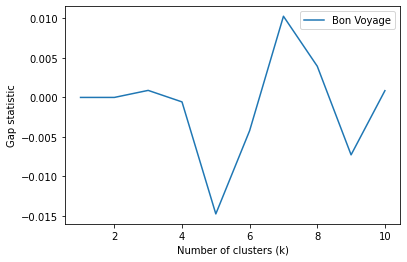

Group: Bon Voyage, Optimal k (gap): 3, Optimal k (gap*): 7


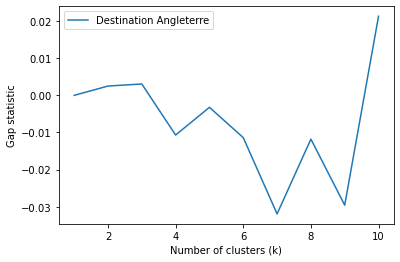

Group: Destination Angleterre, Optimal k (gap): 2, Optimal k (gap*): 10


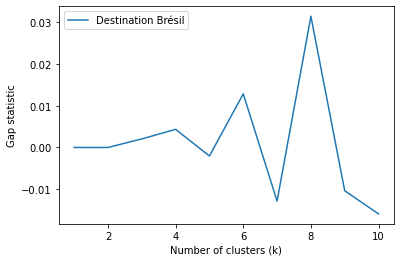

Group: Destination Brésil, Optimal k (gap): 4, Optimal k (gap*): 8


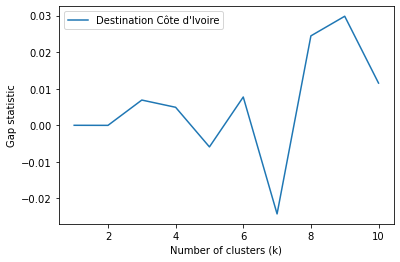

Group: Destination Côte d'Ivoire, Optimal k (gap): 3, Optimal k (gap*): 9


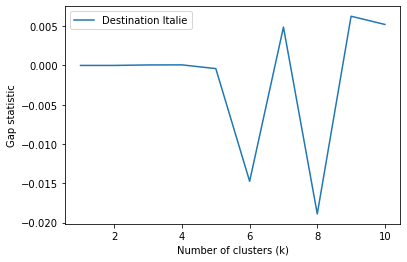

Group: Destination Italie, Optimal k (gap): 3, Optimal k (gap*): 9


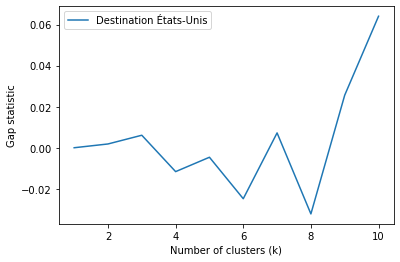

Group: Destination États-Unis, Optimal k (gap): 2, Optimal k (gap*): 10


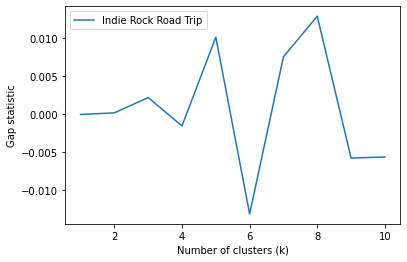

Group: Indie Rock Road Trip, Optimal k (gap): 3, Optimal k (gap*): 8


In [8]:
# Calculate the optimal k
# Loop over each group and generate scree plot
optimal_num_k = {}
optimal_num_k_2 = {}

for group_name, group in groups:
    group_gaps = []
    group_errors = []

    for k in range(1, 11):
        reduced_data = reduced_data_dict[group_name]

        # Compute the gap statistic and standard deviation for the current value of k
        gap, gap_std = compute_gap(reduced_data, k)
        group_gaps.append(gap)
        group_errors.append(gap_std)

    # Find the optimal number of components based on the gap statistic criterion
    optimal_k = None
    for i in range(1, len(group_gaps) - 1):
        s_k = group_errors[i]
        threshold = s_k * np.sqrt(1 + 1 / 20)
        if group_gaps[i] >= group_gaps[i + 1] - threshold:
            optimal_k = i + 1
            break

    if optimal_k is None:
        optimal_k = np.argmax(group_gaps) + 1

    optimal_num_k[group_name] = optimal_k

    # Find the optimal number of components based on the gap* statistic criterion
    for i in range(1, len(group_gaps)):
        optimal_k_2 = np.argmax(group_gaps) + 1

    optimal_num_k_2[group_name] = optimal_k_2

    # Plot the gap statistics
    plt.plot(range(1, 11), group_gaps, label=group_name)

    # Set labels and display the plot
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Gap statistic')
    plt.legend()
    plt.show()

    print(f"Group: {group_name}, Optimal k (gap): {optimal_num_k[group_name]}, Optimal k (gap*): {optimal_num_k_2[group_name]}")


### Apply KMeans

Group Bon Voyage: [1 0 0 2 0 0 1 2 2 0 2 1 2 2 0 0 2 0 2 0 2 2 0 1 0 2 2 0 0 0 2 2 2 1 0 0 2
 0 1 2 2 0 0 1 1 0 0 0 0 1 2 1 2 1 1 2 0 0 2 1 2 0 0 1 1 1 2 0 1 1 2 2 1 0
 0 0 0 2 0 0 0 2 0 1 2 2 2 2 1 2 2 1 2 0 0 2 2 0 2 2]


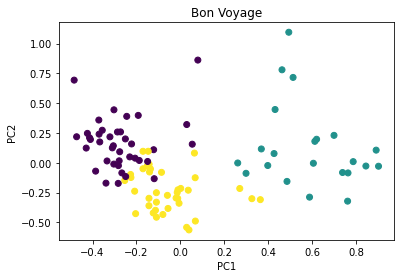

Group Destination Angleterre: [0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0]


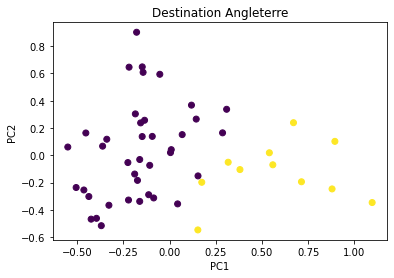

Group Destination Brésil: [0 0 0 3 2 0 0 0 0 2 3 0 2 3 3 0 0 1 3 0 2 2 2 3 2 3 2 0 0 0 0 0 2 0 3 0 3
 1 1 0 3 1 3 0 3 1 3 1 3 1]


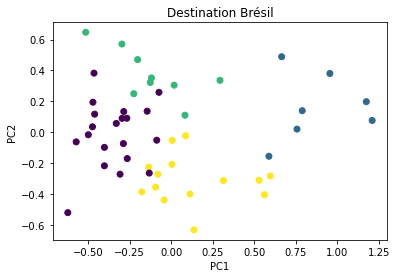

Group Destination Côte d'Ivoire: [1 0 2 0 0 0 0 2 0 1 1 1 0 0 1 1 2 1 1 1 0 0 1 0 0 0 1 1 0 0 2 0 2 0 2 0 1
 0 1 0 0 0 1 0 0]


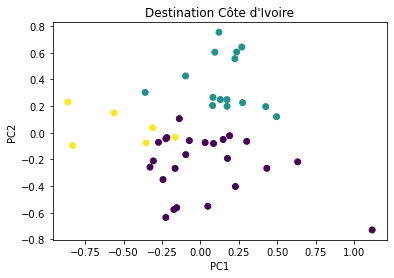

Group Destination Italie: [2 1 1 1 0 2 0 2 0 1 0 2 1 2 0 2 2 2 2 1 2 2 1 1 2 0 0 0 0 2 0 2 2 0 0 0 0
 0 0 0 2 0 0 2 2 2 0 0 0 0 1 2 2 0 2 2 1 2 0 0 0 0 0 0 2 2 2 0 0 0 0 0 1 2
 2 0 1 0 0 1 2 2 0 0 2 2 2 0 0 1 2 2 0 0 1 0 0 2 0 1]


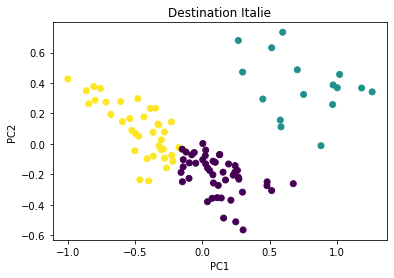

Group Destination États-Unis: [1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0
 0 0 0 1 1 0 1 1 0 1 1 1 0]


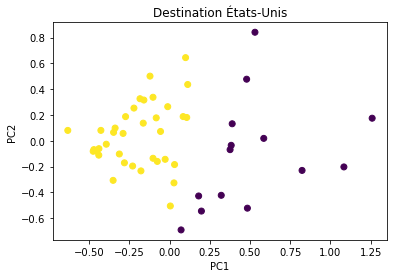

Group Indie Rock Road Trip: [1 1 2 1 1 2 2 1 1 0 2 2 2 0 2 0 1 1 1 0 0 1 1 1 2 1 0 2 2 1 1 2 1 2 1 1 2
 1 1 1 1 1 1 0 2 2 0 1 0 1 1 0 1 2 0 1 2 1 2 1 1 1 0 2 1 1 0 2 2 0 2 1 1 0
 0 1 0 0 0 1 0 1 0 2 2 2 2 2 2 0 2 1 1 2 0 1 0 1 2 1]


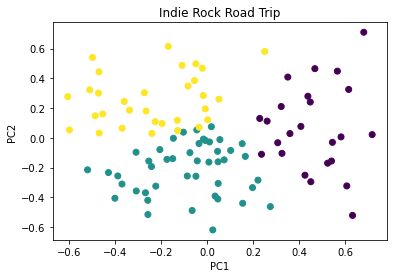

,playlist_name,playlist_followers,playlist_owner,track_name,track__popularity,track_release_date,artist_name,artist_popularity,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster,cluster_2
200,Bon Voyage,115966,Spotify,Tropics,41,2024-08-16,Quantic,62,0.746,0.416,...,0.0383,0.01290,0.887000,0.1160,0.510,118.023,149746,4,1,1
201,Bon Voyage,115966,Spotify,I Can See Clearly Now - Edit,74,1972,Johnny Nash,61,0.681,0.373,...,0.0568,0.63300,0.001130,0.0751,0.623,123.423,164733,4,0,2
202,Bon Voyage,115966,Spotify,Opendoors,73,2019-05-03,Jitwam,62,0.725,0.521,...,0.1360,0.56500,0.275000,0.1780,0.403,114.038,162102,4,0,4
203,Bon Voyage,115966,Spotify,Ghost Town,67,2000-08-21,The Specials,59,0.664,0.765,...,0.0507,0.04930,0.333000,0.1130,0.907,73.676,219307,4,2,1
204,Bon Voyage,115966,Spotify,Ring of Fire,67,1963-08-06,Johnny Cash,76,0.659,0.585,...,0.0288,0.62300,0.000213,0.3480,0.784,104.111,158427,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,Indie Rock Road Trip,1114408,Spotify,Coins,43,2016-09-09,Local Natives,57,0.566,0.576,...,0.0365,0.05780,0.000000,0.0523,0.607,138.045,237693,4,1,0
396,Indie Rock Road Trip,1114408,Spotify,Gold and Green,43,2017-10-27,"Slaughter Beach, Dog",51,0.651,0.505,...,0.0351,0.71600,0.000024,0.0910,0.387,76.506,187696,4,0,5
397,Indie Rock Road Trip,1114408,Spotify,I'm in Love,43,2024-01-19,Jelani Aryeh,50,0.655,0.788,...,0.0328,0.00937,0.077200,0.1920,0.930,142.013,196724,4,1,1
398,Indie Rock Road Trip,1114408,Spotify,Lazy Eye,42,2006-01-01,Silversun Pickups,55,0.635,0.836,...,0.0468,0.04090,0.726000,0.1160,0.256,127.390,354347,4,2,4


In [9]:
# Apply KMeans with optimal number of clusters
df = pd.DataFrame()

kmeans_dict = {}
kmeans_2_dict = {}
cluster_labels_dict = {}
cluster_labels_2_dict = {}

for group_name, group in groups:
    reduced_data = reduced_data_dict[group_name]

    k = optimal_num_k[group_name]
    k_2 = optimal_num_k_2[group_name]

    # Apply KMeans with optimal number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42).fit(reduced_data)
    kmeans_2 = KMeans(n_clusters=k_2, random_state=42).fit(reduced_data)
    
    kmeans_dict[group_name] = kmeans
    kmeans_2_dict[group_name] = kmeans_2

    cluster_labels_dict[group_name] = kmeans.labels_
    cluster_labels_2_dict[group_name] = kmeans_2.labels_

    print(f"Group {group_name}: {kmeans.labels_}")

    # Assign cluster labels to original group data
    group = group.assign(cluster=kmeans.labels_)
    group = group.assign(cluster_2=kmeans_2.labels_)

    # Append group to original dataframe
    df = pd.concat([df, group])
    
    # Plot clusters
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(group_name)
    plt.show()

display(df)


## Variables creation

### HH-Index

In [10]:
groups = df.groupby('playlist_name')


In [11]:
# Calculate the shares of each cluster
shares_perc = {}

for group_name, group in groups:
    shares = group['cluster'].value_counts(normalize=True)
    shares_perc[group_name] = shares * 100

# Calculate the HHI
hhi = {}
hhi_2 = {}

for group_name, group in groups:
  shares = group['cluster'].value_counts(normalize=True)
  hhi[group_name] = sum((shares*100)**2)

  shares_2 = group['cluster_2'].value_counts(normalize=True)
  hhi_2[group_name] = sum((shares_2*100)**2)

print(hhi)
print(hhi_2)

print("Minimum HHI: ", min(hhi.values()))
print("Mean HHI: ", np.mean(list(hhi.values())))
print("Median HHI: ", np.median(list(hhi.values())))
print("Maximum HHI: ", max(hhi.values()))
print("Standard deviation: ", np.std(list(hhi.values())))


{'Bon Voyage': 3526.0, 'Destination Angleterre': 6568.0, 'Destination Brésil': 2904.0, "Destination Côte d'Ivoire": 4133.333333333333, 'Destination Italie': 3834.0, 'Destination États-Unis': 5968.0, 'Indie Rock Road Trip': 3562.0}
{'Bon Voyage': 1698.0, 'Destination Angleterre': 1296.0, 'Destination Brésil': 1408.0, "Destination Côte d'Ivoire": 1427.1604938271607, 'Destination Italie': 1408.0, 'Destination États-Unis': 1608.0, 'Indie Rock Road Trip': 1550.0}
Minimum HHI:  2904.0
Mean HHI:  4356.47619047619
Median HHI:  3834.0
Maximum HHI:  6568.0
Standard deviation:  1267.2349459209468


### Euclidean distances

In [12]:
# Calculate distances between cluster centroids
distances_dict = {}
distances_dict_2 = {}

for group_name, group in groups:
    # Get the cluster centroids for the group
    cluster_centroids = kmeans_dict[group_name].cluster_centers_
    cluster_centroids_2 = kmeans_2_dict[group_name].cluster_centers_

    # Calculate pairwise euclidean distances between cluster centroids
    distances = pairwise_distances(cluster_centroids)
    distances_2 = pairwise_distances(cluster_centroids_2)

    # Calculate mean pairwise distance
    mean_distance = distances.mean()
    mean_distance_2 = distances_2.mean()

    # Print mean pairwise distance for the group
    print(f"Group {group_name}: Mean pairwise distance between cluster centroids = {mean_distance}")

    distances_dict[group_name] = mean_distance
    distances_dict_2[group_name] = mean_distance_2

# Calculate max, min, mean, median and standard deviation of distances
distances_list = [d for distances in distances_dict.values() for d in distances.flatten() if not np.isnan(d)]
print(f"Max distance: {np.max(distances_list):.5f}")
print(f"Min distance: {np.min(distances_list):.5f}")
print(f"Mean distance: {np.mean(distances_list):.5f}")
print(f"Median distance: {np.median(distances_list):.5f}")
print(f"Standard deviation of distances: {np.std(distances_list):.5f}")


Group Bon Voyage: Mean pairwise distance between cluster centroids = 0.474888312103895
Group Destination Angleterre: Mean pairwise distance between cluster centroids = 0.3937161293725913
Group Destination Brésil: Mean pairwise distance between cluster centroids = 0.6765679567194846
Group Destination Côte d'Ivoire: Mean pairwise distance between cluster centroids = 0.5218273564209651
Group Destination Italie: Mean pairwise distance between cluster centroids = 0.6274892068530671
Group Destination États-Unis: Mean pairwise distance between cluster centroids = 0.37024602834184944
Group Indie Rock Road Trip: Mean pairwise distance between cluster centroids = 0.4136483470358501
Max distance: 0.67657
Min distance: 0.37025
Mean distance: 0.49691
Median distance: 0.47489
Standard deviation of distances: 0.10958


In [13]:
# Calculate distances bewteen tracks
scaler = MinMaxScaler()

selected_columns = [
    "danceability", "energy", "loudness", "speechiness", 
    "acousticness", "instrumentalness", "liveness", "valence", 
    "tempo", "duration_ms"
]

distances_dict_3 = {}

for group_name, group in groups:
    subset = group.loc[:, selected_columns]
    scaled_columns = scaler.fit_transform(subset)

    pairwise_dist = pairwise_distances(scaled_columns)
    mean_distance = pairwise_dist.mean()
    
    # Print mean pairwise distance for the group
    print(f"Group {group_name}: Mean pairwise distance between tracks = {mean_distance}")

    distances_dict_3[group_name] = mean_distance

# Calculate max, min, mean, median and standard deviation of distances
distances_list = [d for distances in distances_dict_3.values() for d in distances.flatten() if not np.isnan(d)]
print(f"Max distance: {np.max(distances_list):.5f}")
print(f"Min distance: {np.min(distances_list):.5f}")
print(f"Mean distance: {np.mean(distances_list):.5f}")
print(f"Median distance: {np.median(distances_list):.5f}")
print(f"Standard deviation of distances: {np.std(distances_list):.5f}")


Group Bon Voyage: Mean pairwise distance between tracks = 0.9639658928252766
Group Destination Angleterre: Mean pairwise distance between tracks = 0.9845606712656257
Group Destination Brésil: Mean pairwise distance between tracks = 1.014116961844158
Group Destination Côte d'Ivoire: Mean pairwise distance between tracks = 0.9981771299687493
Group Destination Italie: Mean pairwise distance between tracks = 0.9551075595740007
Group Destination États-Unis: Mean pairwise distance between tracks = 0.9660098610181037
Group Indie Rock Road Trip: Mean pairwise distance between tracks = 0.8906149049983604
Max distance: 1.01412
Min distance: 0.89061
Mean distance: 0.96751
Median distance: 0.96601
Standard deviation of distances: 0.03681


### Stirling diversity index

In [14]:
# k-alpha Rao-Stirling index
stirling_index_dict = {}

for group_name, group in groups:
    clusters = group.groupby('cluster')

    total_index = 0

    cluster_centroids = kmeans_dict[group_name].cluster_centers_
    
    for i, (cluster_i_name, cluster_i) in enumerate(clusters):
        for j, (cluster_j_name, cluster_j) in enumerate(clusters):
            if i >= j:
                continue
            
            centroid_i = cluster_centroids[i]
            centroid_j = cluster_centroids[j]
            dist = cdist([centroid_i], [centroid_j], 'euclidean')

            share_i = len(cluster_i) / len(group)
            share_j = len(cluster_j) / len(group)

            index = dist * share_i * share_j

            total_index += index

    stirling_index_dict[group_name] = total_index

print(stirling_index_dict)

print("Minimum index: ", min(stirling_index_dict.values()))
print("Mean index: ", np.mean(list(stirling_index_dict.values())))
print("Median index: ", np.median(list(stirling_index_dict.values())))
print("Maximum index: ", max(stirling_index_dict.values()))
print("Standard deviation: ", np.std(list(stirling_index_dict.values())))


{'Bon Voyage': array([[0.21671734]]), 'Destination Angleterre': array([[0.13512338]]), 'Destination Brésil': array([[0.29366367]]), "Destination Côte d'Ivoire": array([[0.20991476]]), 'Destination Italie': array([[0.25842579]]), 'Destination États-Unis': array([[0.1492832]]), 'Indie Rock Road Trip': array([[0.19222261]])}
Minimum index:  [[0.13512338]]
Mean index:  0.20790724930452034
Median index:  0.2099147617877705
Maximum index:  [[0.29366367]]
Standard deviation:  0.05205520955567529


In [15]:
# k-beta Rao-Stirling index
stirling_index_2_dict = {}

for group_name, group in groups:
    clusters = group.groupby('cluster_2')

    total_index = 0

    cluster_centroids = kmeans_2_dict[group_name].cluster_centers_
    
    for i, (cluster_i_name, cluster_i) in enumerate(clusters):
        for j, (cluster_j_name, cluster_j) in enumerate(clusters):
            if i >= j:
                continue
            
            centroid_i = cluster_centroids[i]
            centroid_j = cluster_centroids[j]
            dist = cdist([centroid_i], [centroid_j], 'euclidean')

            share_i = len(cluster_i) / len(group)
            share_j = len(cluster_j) / len(group)

            index = dist * share_i * share_j

            total_index += index

    stirling_index_2_dict[group_name] = total_index

print(stirling_index_2_dict)

print("Minimum index: ", min(stirling_index_2_dict.values()))
print("Mean index: ", np.mean(list(stirling_index_2_dict.values())))
print("Median index: ", np.median(list(stirling_index_2_dict.values())))
print("Maximum index: ", max(stirling_index_2_dict.values()))
print("Standard deviation: ", np.std(list(stirling_index_2_dict.values())))


{'Bon Voyage': array([[0.30851409]]), 'Destination Angleterre': array([[0.36823745]]), 'Destination Brésil': array([[0.36971912]]), "Destination Côte d'Ivoire": array([[0.3662985]]), 'Destination Italie': array([[0.36019507]]), 'Destination États-Unis': array([[0.35544489]]), 'Indie Rock Road Trip': array([[0.29929288]])}
Minimum index:  [[0.29929288]]
Mean index:  0.3468145697709208
Median index:  0.36019506918106703
Maximum index:  [[0.36971912]]
Standard deviation:  0.02762488623363251


## Append to dataframe

In [16]:
# Append playlist-level indicators
panel_data = []

for group_name, group in groups:
    # Retrieve playlist-level indicators
    # Variety
    nb_clusters = optimal_num_k[group_name]
    nb_clusters_2 = optimal_num_k_2[group_name]

    # Balance
    hh_index = hhi[group_name]
    hh_index_2 = hhi_2[group_name]

    # Distparity
    distances = distances_dict[group_name]
    distances_2 = distances_dict_2[group_name]
    distances_3 = distances_dict_3[group_name]

    # Diversity
    stirling_index = stirling_index_dict[group_name]
    stirling_index_2 = stirling_index_2_dict[group_name]
    
    # Add playlist-level indicators to each track in the playlist
    for _, track in group.iterrows():
        track_data = track.to_dict()
        track_data.update({
            'nb_clusters': nb_clusters,
            'nb_clusters_2': nb_clusters_2,
            'hh_index': hh_index,
            'hh_index_2': hh_index_2,
            'distances': distances,
            'distances_2': distances_2,
            'distances_3': distances_3,
            'stirling_index': stirling_index,
            'stirling_index_2': stirling_index_2
        })
        panel_data.append(track_data)

# Convert to DataFrame
panel_data_df = pd.DataFrame(panel_data)
display(panel_data_df)


,playlist_name,playlist_followers,playlist_owner,track_name,track__popularity,track_release_date,artist_name,artist_popularity,danceability,energy,...,cluster_2,nb_clusters,nb_clusters_2,hh_index,hh_index_2,distances,distances_2,distances_3,stirling_index,stirling_index_2
0,Bon Voyage,115966,Spotify,Tropics,41,2024-08-16,Quantic,62,0.746,0.416,...,1,3,7,3526.0,1698.0,0.474888,0.715906,0.963966,[[0.2167173446102605]],[[0.30851408604075226]]
1,Bon Voyage,115966,Spotify,I Can See Clearly Now - Edit,74,1972,Johnny Nash,61,0.681,0.373,...,2,3,7,3526.0,1698.0,0.474888,0.715906,0.963966,[[0.2167173446102605]],[[0.30851408604075226]]
2,Bon Voyage,115966,Spotify,Opendoors,73,2019-05-03,Jitwam,62,0.725,0.521,...,4,3,7,3526.0,1698.0,0.474888,0.715906,0.963966,[[0.2167173446102605]],[[0.30851408604075226]]
3,Bon Voyage,115966,Spotify,Ghost Town,67,2000-08-21,The Specials,59,0.664,0.765,...,1,3,7,3526.0,1698.0,0.474888,0.715906,0.963966,[[0.2167173446102605]],[[0.30851408604075226]]
4,Bon Voyage,115966,Spotify,Ring of Fire,67,1963-08-06,Johnny Cash,76,0.659,0.585,...,2,3,7,3526.0,1698.0,0.474888,0.715906,0.963966,[[0.2167173446102605]],[[0.30851408604075226]]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,Indie Rock Road Trip,1114408,Spotify,Coins,43,2016-09-09,Local Natives,57,0.566,0.576,...,0,3,8,3562.0,1550.0,0.413648,0.703050,0.890615,[[0.1922226066172631]],[[0.29929287567472307]]
491,Indie Rock Road Trip,1114408,Spotify,Gold and Green,43,2017-10-27,"Slaughter Beach, Dog",51,0.651,0.505,...,5,3,8,3562.0,1550.0,0.413648,0.703050,0.890615,[[0.1922226066172631]],[[0.29929287567472307]]
492,Indie Rock Road Trip,1114408,Spotify,I'm in Love,43,2024-01-19,Jelani Aryeh,50,0.655,0.788,...,1,3,8,3562.0,1550.0,0.413648,0.703050,0.890615,[[0.1922226066172631]],[[0.29929287567472307]]
493,Indie Rock Road Trip,1114408,Spotify,Lazy Eye,42,2006-01-01,Silversun Pickups,55,0.635,0.836,...,4,3,8,3562.0,1550.0,0.413648,0.703050,0.890615,[[0.1922226066172631]],[[0.29929287567472307]]


In [17]:
# Export to Excel
panel_data_df.to_excel("df_voyage_final.xlsx", index=False)
